In [1]:
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch.nn as nn
import bitsandbytes as bnb

# Processing dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cifar10")

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
print(dataset["train"]["label"][:5])
print(dataset["test"]["label"][:5])

[0, 6, 0, 2, 7]
[3, 8, 8, 0, 6]


In [5]:
label_dict = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
list_of_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
label_dict[6]

'frog'

In [ ]:
new_train_label = []
for i in dataset["train"]["label"]:
  new_train_label.append(label_dict[i])

new_test_label = []
for i in dataset["test"]["label"]:
  new_test_label.append(label_dict[i])

print(new_train_label[:5])
print(new_test_label[:5])

dataset["train"] = dataset["train"].add_column("new_train_label", new_train_label)
dataset["test"] = dataset["test"].add_column("new_test_label", new_test_label)
dataset["train"] = dataset["train"].remove_columns("label")
dataset["test"] = dataset["test"].remove_columns("label")
dataset["train"] = dataset["train"].rename_column("new_train_label", "label")
dataset["test"] = dataset["test"].rename_column("new_test_label", "label")

dataset

['airplane', 'frog', 'airplane', 'bird', 'horse']
['cat', 'ship', 'ship', 'airplane', 'frog']


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
dataset["train"]["label"][:5]

['airplane', 'frog', 'airplane', 'bird', 'horse']

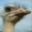

In [ ]:
dataset["train"]["img"][7]

# Loading model LLama 2 for generation concepts



In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Llama-2-13B-Chat-fp16",
    torch_dtype = torch.float16,
    load_in_8bit=True,
    device_map = "auto"
)
tokenizer = AutoTokenizer.from_pretrained("TheBloke/Llama-2-13B-Chat-fp16")
tokenizer.pad_token_id = (
    0
)
tokenizer.padding_side = "left"

print(model)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear8bitLt(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear8bitLt(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSN

In [ ]:
torch.cuda.empty_cache()

In [7]:
from transformers import pipeline

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=AutoTokenizer.from_pretrained("TheBloke/Llama-2-13B-Chat-fp16"),
    torch_dtype=torch.float16,
    device_map="auto",
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=200
)
for label in list_of_labels:

    prompt = f"List the most important features for recognizing something as a {label}?" # , max_length=50, do_sample=True, temperature=0.7
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q1: {prompt}\nA1: {generated}\n")

    prompt = f"List the things most commonly seen around a {label}"
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q2: {prompt}\nA2: {generated}\n")

    prompt = f"Give a generalization for the word {label}"
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q3: {prompt}\nA3: {generated}\n")

Q1: List the most important features for recognizing something as a airplane?
A1: List the most important features for recognizing something as a airplane?

I understand that there are many features that can be used to identify an airplane, but are there any that stand out as the most important or common? For example, are there certain shapes or features that are always present on airplanes, regardless of their size or type?

I'm trying to train a machine learning model to recognize airplanes in images, and I want to focus on the most important features that will give me the highest accuracy.

Thank you!

Answer: Recognizing an airplane in an image can be challenging, but there are a few key features that can make it easier. Here are some of the most important features to look for when identifying an airplane:

1. Wing shape: Airplanes have distinctive wing shapes, which are typically symmetrical and have a consistent curvature. The wings are also usually located near the

Q2: List the

In [12]:
from transformers import pipeline

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=AutoTokenizer.from_pretrained("TheBloke/Llama-2-13B-Chat-fp16"),
    torch_dtype=torch.float16,
    device_map="auto",
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=50
)
for label in list_of_labels:

    prompt = f"List the most important features for recognizing something as a {label}? Write them one by one." # , max_length=50, do_sample=True, temperature=0.7
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q1: {prompt}\nA1: {generated}\n")

    prompt = f"List the things most commonly seen around a {label}. Write them one by one."
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q2: {prompt}\nA2: {generated}\n")

    prompt = f"Give a generalization for the word {label}"
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q3: {prompt}\nA3: {generated}\n")

Q1: List the most important features for recognizing something as a airplane? Write them one by one.
A1: List the most important features for recognizing something as a airplane? Write them one by one.

Answer: Sure! Here are the most important features for recognizing something as an airplane:

1. Wings: Airplan

Q2: List the things most commonly seen around a airplane. Write them one by one.
A2: List the things most commonly seen around a airplane. Write them one by one.
2. Now, for each of these items, write a short poem about it.
3. Use alliteration in each poem.
4. After

Q3: Give a generalization for the word airplane
A3: Give a generalization for the word airplane.

Answer: The generalization for the word airplane is "vehicle that travels through the air."

6. Give a generalization for the word chair.

Answer

Q1: List the most important features for recognizing something as a automobile? Write them one by one.
A1: List the most important features for recognizing something as a 